### To classify shapes in an image using Deep Learning

In [ ]:
# installing dependencies
%pip install comet_ml --quiet  # install comet_ml for visualising results and logging

# importing libraries
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import random
import time
from tqdm.notebook import tqdm
from comet_ml import Experiment
from sklearn.utils import shuffle
import tensorflow as tf
import pickle
import gdown

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### *Change image from .tif to .png*

Input images are in .tif format which needs to be changed into jpeg/png for our image detection to work.


In [ ]:
# Class labels are numbered EACH FOR ['disc', 'gear', 'hexagon', 'square'] AS dictionary
class_labels = {'disc':0, 'gear':1, 'hexagon':2, 'square':3}
# or class_labels = [0,1,2,3]

input_directory= f'/content/drive/MyDrive/Colab Notebooks/Achira/input_images/input_tiff'
output_directory=f'/content/drive/MyDrive/Colab Notebooks/Achira/input_images/photo_in_numbers'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Reading in IMREAD_GRAYSCALE to prevent shift in color

for filename in os.listdir(input_directory):
    # Read the image in grayscale
    img = cv2.imread(os.path.join(input_directory, filename), cv2.IMREAD_GRAYSCALE)
    key = os.path.splitext(filename)[0]

    # Create the new filename with a .png extension
    new_filename = str(class_labels[key]) + '.png'

    # Save the grayscale image as a .png in the output directory
    cv2.imwrite(os.path.join(output_directory, new_filename), img)


In [15]:
# plotting a sample image
image_path = f'output_directory/1.png'
img1 = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
# Since cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
# to crash; see https://github.com/jupyter/notebook/issues/3935
"""
cv2.imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""
# we'll use PIL Image
from PIL import Image
plt.imshow(img1)
plt.show()

### Reading the image

In [16]:
class Gen():
  def __init__(self, input_path, M = 1024, M1 = 1024, num = 1000):

    # setting output dimensions as required
    # M x M1 is dimensions of output image (default 1024x1024),
    # num is total number of images to be genrated (default 100, can take 1000 too)
    self.dim = M
    self.dim1 = M1
    # If wish to take dimensions input , we can use second method as shown - dim = int(input("Enter image dimensions")) # OR 256*(2**(nout+1))
    self.num = num
    # input path for taking images
    self.input_path = input_path
    # to store data for each image
    self.samples = []
    self.labels = []

  def generate_images(self,N,k):

    # given output image will contain k images of each type
    # N is no of shapes we need to identify (here 4)

    for j in range(1, N + 1): # For N shapes
        image_path = f'{self.input_path}/{j}.jpg' # Reading N images from the input folder assuming images are named as per their type ie disc is named 1.jpg and so on. If not , need to do that before processing here
        sample = cv2.imread(image_path) # add
        self.samples.append(sample)
        self.labels.append(j-1) # Label for the type, ranging from 0 to 3

    #creating ground truth labels named gt
    gt = list(zip(self.samples, self.labels))

    # Calculating the number of images here
    n = int(self.dim/64) # or since M=M1 here we are using either of them, else use samples[0].size[0]
    num_images = N*k # if N = 5 ie 5 shapes and k = 20 ie 20 instances of each type per image , then num_images = 5*20 = 100
    #num_images = int(input("Enter number of images needed: \n"))

    # divide the background into grids for better selection of coordinates
    all_dims = [(i * 64,j * 64) for i in range(n) for j in range(n)]

    # start of image generation
    for nout in range(self.num):
        # making a black background
        bg_image = np.zeros((self.dim, self.dim1, 3), np.uint8)
        # Alternative method => bg_image = Image.new('RGB', out_dims, (5, 5, 5)) or Image.new("RGB", out_dims, "black")

        # Create a list to store the images, positions, and ground truth labels
        image_data = []
        # to store dimensions (x,y) generated randomly
        dims = []
        # finding non-overlapping positions
        dims = random.sample(all_dims,num_images)

        for i in range(0, num_images, N):
            for j in range(N):
                # getting x,y coordinate of image
                x, y = dims[i+j]

                # creating a copy of original data before transformation
                img,label = gt[j] # or samples[j].copy

                # random scaling bw 0.75 to 0.95 , here we not scaling from .75 to 1.0
                # as latter will lead to shapes overlapping with each other in some cases
                scale_factor = random.uniform(0.75,0.95)
                img = cv2.resize(img,(0,0), fx = scale_factor, fy = scale_factor)

                # random rotation bw 0 to 90 degree
                angle = random.uniform(0,90)
                M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1)
                img = cv2.warpAffine(img, M, (img.shape[1],img.shape[0]))

                # Paste the four images at the selected positions
                bg_image[y:y+img.shape[1], x:x+img.shape[0]] = img

                # Getting centroid and width & hieght of image

                x1 = (x+(img.shape[1]//2))/1024 # normalised x coordinate of centroid
                y1 = (y+(img.shape[0]//2))/1024 # normalised y coordinate of centroid

                h = img.shape[0]/1024  # Normalized dimensions Hieght and Width
                w = img.shape[1]/1024

                # append the ground truth label
                image_data.append((label,x1,y1,w,h))

        # Saving the file in output directory
        output_filename = f'/content/drive/MyDrive/Colab Notebooks/Achira/gen2/images2/gen_image_{nout}.png'
        cv2.imwrite(output_filename, bg_image)

        # Save the corresponding annotation file
        with open(f'/content/drive/MyDrive/Colab Notebooks/Achira/gen2/labels2/gen_image_{nout}.txt', 'w') as file:
          for obj in image_data: # reading the annotated data stored as tuples
            label,x1,y1,w,h = obj # getting (label,centroid x, centroid y, width, height) as tuple
            file.write(f"{label} {x1} {y1} {w} {h}\n")

    #images.append(image_data)
    print("success") # test check


In [ ]:
# Creating class object 'G'
# can take input path as input_path = str(input("Enter path of original images: "))
input_path = f'/content/drive/MyDrive/Colab Notebooks/Achira/input_images/photo_in_numbers'

G = Gen(input_path=input_path, M=1024, M1=1024, num=100)
G.generate_images(N=4, k=10)

## Part 2

**Now that we've built our training images, let's train our model**

In [ ]:
#Cloning the official YOLOv5 repository and other dependencies
!git clone https://github.com/ultralytics/yolov5
!pip install -U pycocotools

#Installing dependencies
!pip install -qr yolov5/requirements.txt
!cp yolov5/requirements.txt ./

In [ ]:
# splitting into train , test and validation in 80:10:10 ratio
train_size, val_size, test_size = int(0.8*num) , int(0.1*num), int(0.1*num)

# Number for training images
num = 100

# Creating respective folders for Train, Test and Validation

with open('/content/dataset/train.txt', 'w') as file:
  for image_idx in range(train_size):  # for 80 training images
      file.write(f"/content/dataset/images/train/cell_{image_idx}.png\n")

# Repeat for validation and test images
with open('/content/dataset/val.txt', 'w') as file:
  for image_idx in range(train_size, (train_size+val_size)):  # for 10 validation images
      file.write(f"/content/dataset/images/val/cell_{image_idx}.png\n")

with open('/content/dataset/test.txt', 'w') as file:
  for image_idx in range((train_size+val_size),nout):  # for 10 test images
    file.write(f"/content/Datasets/test/test/cell_{image_idx}.png\n")

# Creating YAML file for YOLOv5 training

data_yaml = {
    'nc': 4,
    'names': ['disc', 'gear', 'hexagon', 'square'],
    'train': '../dataset/train.txt',
    'val': '../dataset/val.txt'
    }

# Save to YAML file
with open('/content/dataset/data.yaml', 'w') as file:
    yaml.dump(data_yaml, file)

### Training the model

In [13]:
# for logging and visualising results
# import comet_ml
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="CtAieVOh0tV0S1csxt7zLre1p",
    project_name="rbc",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: You are trying to log string value as a metric. This is not recommended.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tkthefirstone/rbc/20075cd54bbb4c40a007f0377e26da14



In [ ]:
# Train YOLOv5 Model
!python yolov5/train.py --img 1024 --batch 20  --epochs 10 --data /content/dataset/data.yaml
# Or with custom Hyper Parameters
#!python yolov5/train.py --img 640 --batch 16 --epochs 300 -lr 0.001 --workers=1 --data /content/<path name>.yaml --weights '' --cfg yolov5s.yaml/yolov5m.yaml/yolov5l.yaml/yolov5x.yaml --cache

train: weights=yolov5/yolov5s.pt, cfg=, data=/content/dataset/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=10, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-211-g94e943e Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.

In [ ]:
"""
@title
logger = 'Comet' #@param ['Comet', 'ClearML', 'TensorBoard']

if logger == 'Comet':
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  # alternatively we can use tensorboard for data logging during model training
  from tensorboard import notebook
  %load_ext tensorboard
  %tensorboard --logdir runs/train # or /content/yolov5/runs/train
  notebook.display(port=6006, height=1000)
"""

In [28]:
# running inference on sample image

!python /content/yolov5/detect.py --weights /content/sample_data/best.pt --img 1024 --conf 0.50  --source /content/sample_data/gen_image_93.png
# !python detect.py --weights yolov5s.pt --img 1024 --conf 0.25 --source data/images

detect: weights=['/content/sample_data/best.pt'], source=/content/sample_data/gen_image_93.png, data=yolov5/data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/sample_data/gen_image_93.png: 1024x1024 10 discs, 10 gears, 9 hexagons, 16 squares, 22.8ms
Speed: 1.4ms pre-process, 22.8ms inference, 22.1ms NMS per image at shape (1, 3, 1024, 1024)
Results saved to yolov5/runs/detect/exp3


In [ ]:
# ** Fixing some dependency issues by reinstalling a specific stable version of PyTorch. Need to restart runtime after this.**
!pip uninstall torch
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-30 Python-3.10.12 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 1024x1024 11 discs, 10 gears, 13 hexagons, 20 squares
Speed: 16.4ms pre-process, 13.8ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


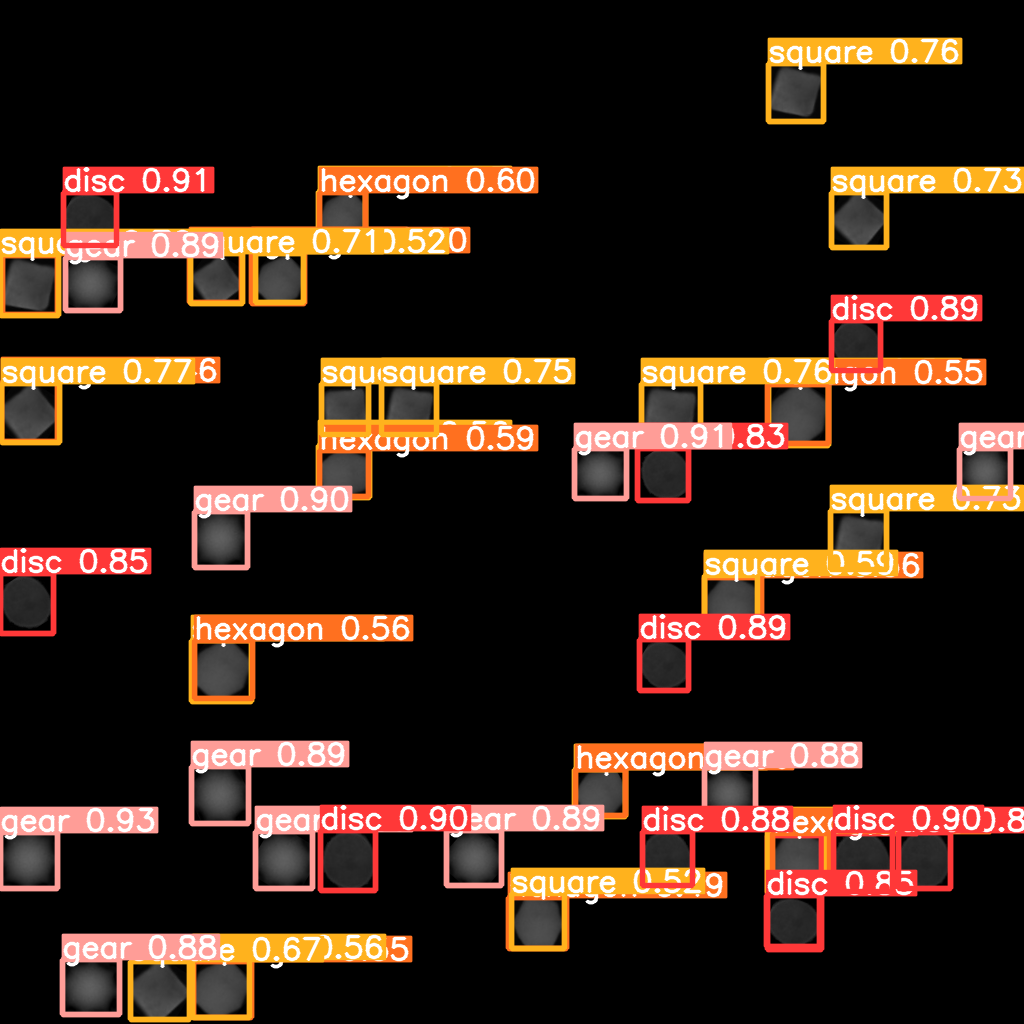

image 1/1: 1024x1024 11 discs, 10 gears, 15 hexagons, 20 squares
Speed: 32.8ms pre-process, 17.7ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)


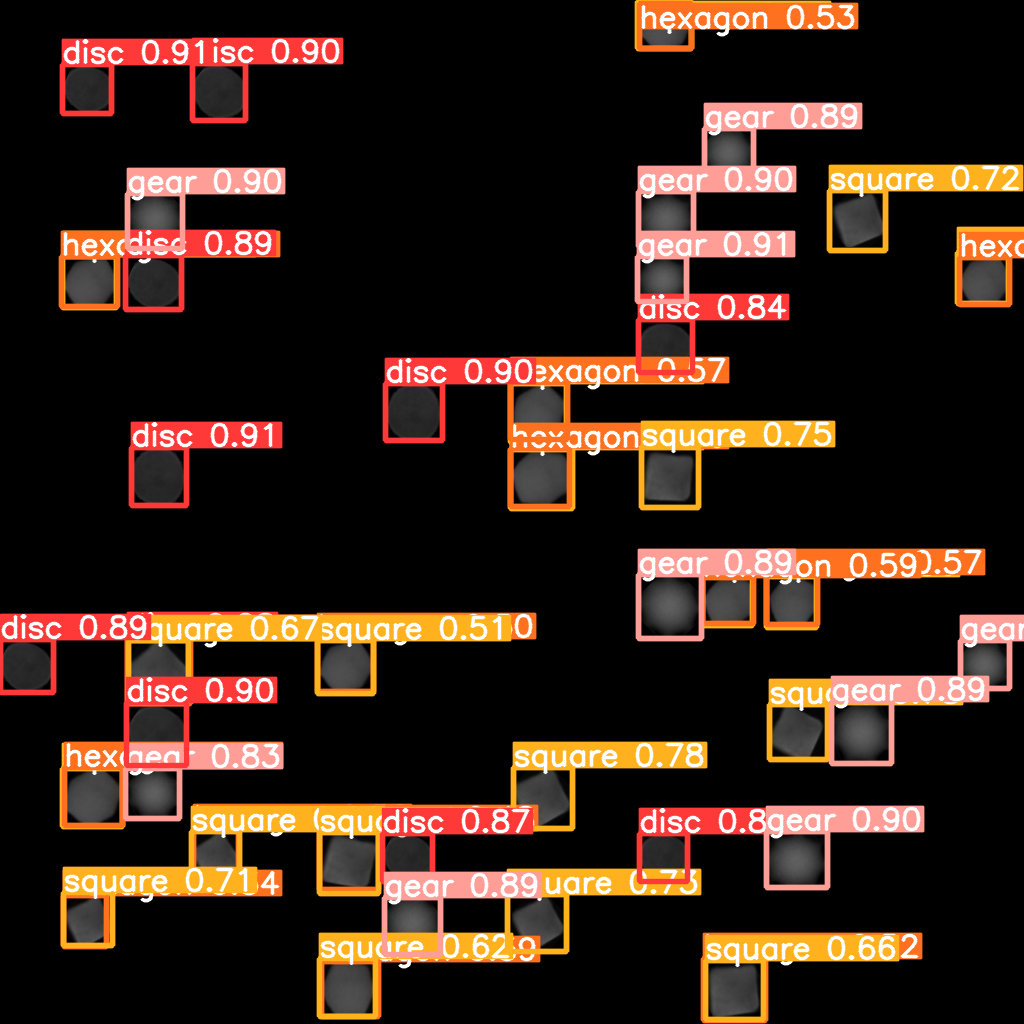

image 1/1: 1024x1024 10 discs, 12 gears, 14 hexagons, 20 squares
Speed: 25.3ms pre-process, 17.2ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


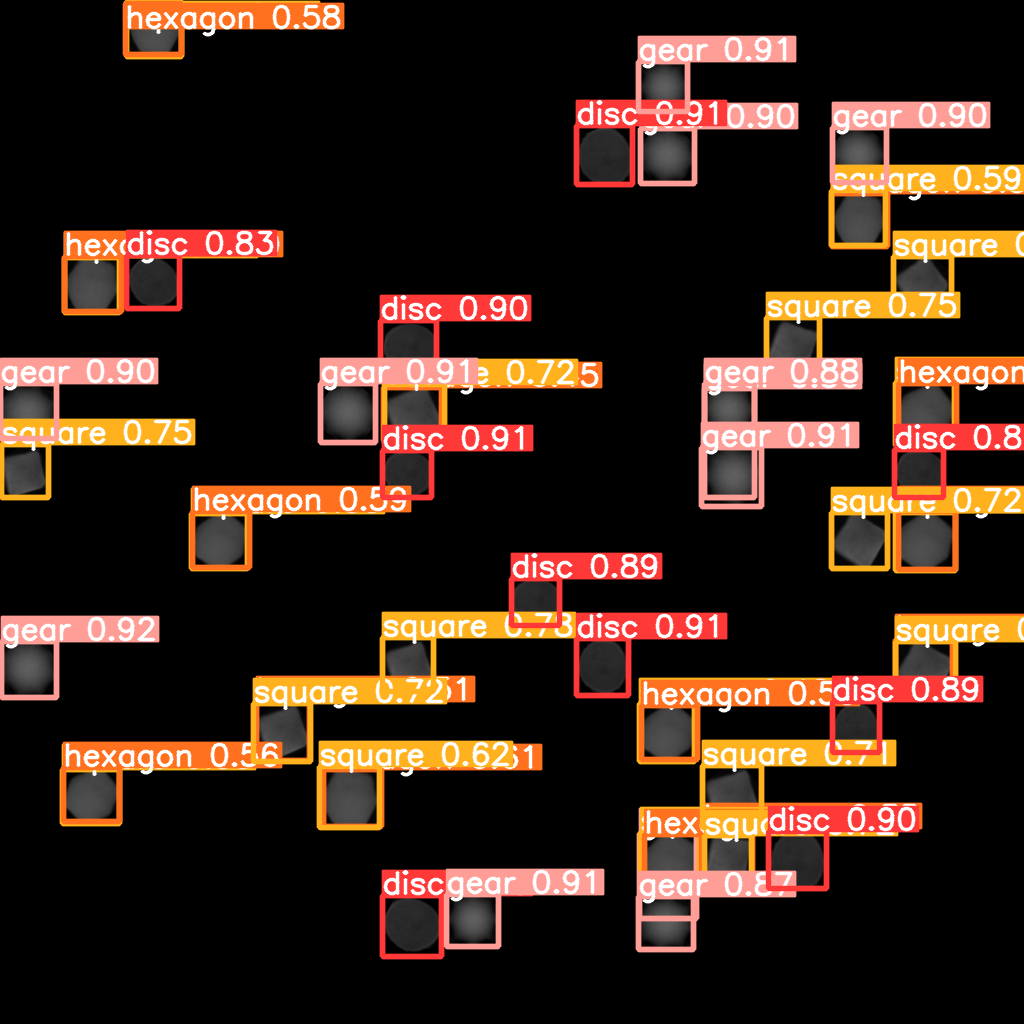

image 1/1: 1024x1024 12 discs, 11 gears, 17 hexagons, 21 squares
Speed: 40.8ms pre-process, 16.6ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)


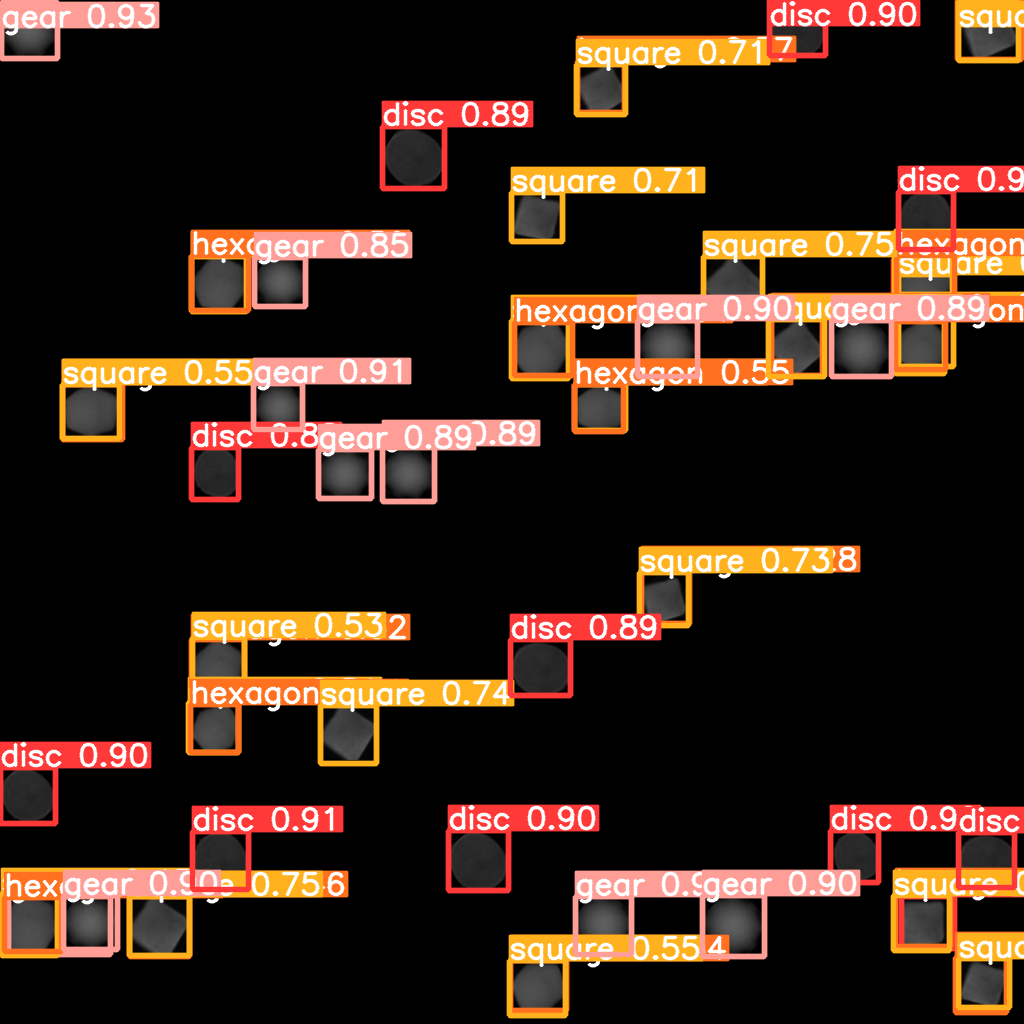

image 1/1: 1024x1024 10 discs, 10 gears, 14 hexagons, 22 squares
Speed: 22.7ms pre-process, 16.0ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


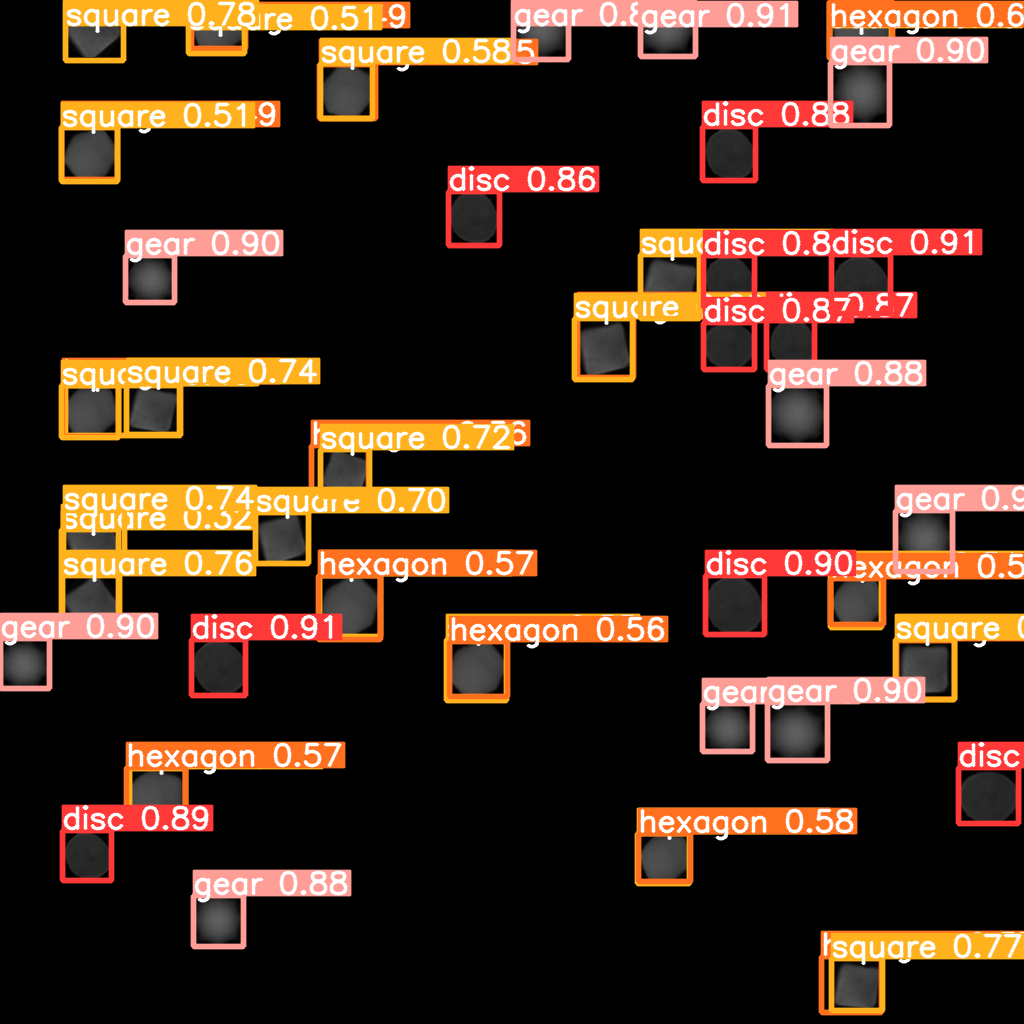

image 1/1: 1024x1024 12 discs, 10 gears, 12 hexagons, 20 squares
Speed: 22.3ms pre-process, 21.9ms inference, 1.9ms NMS per image at shape (1, 3, 640, 640)


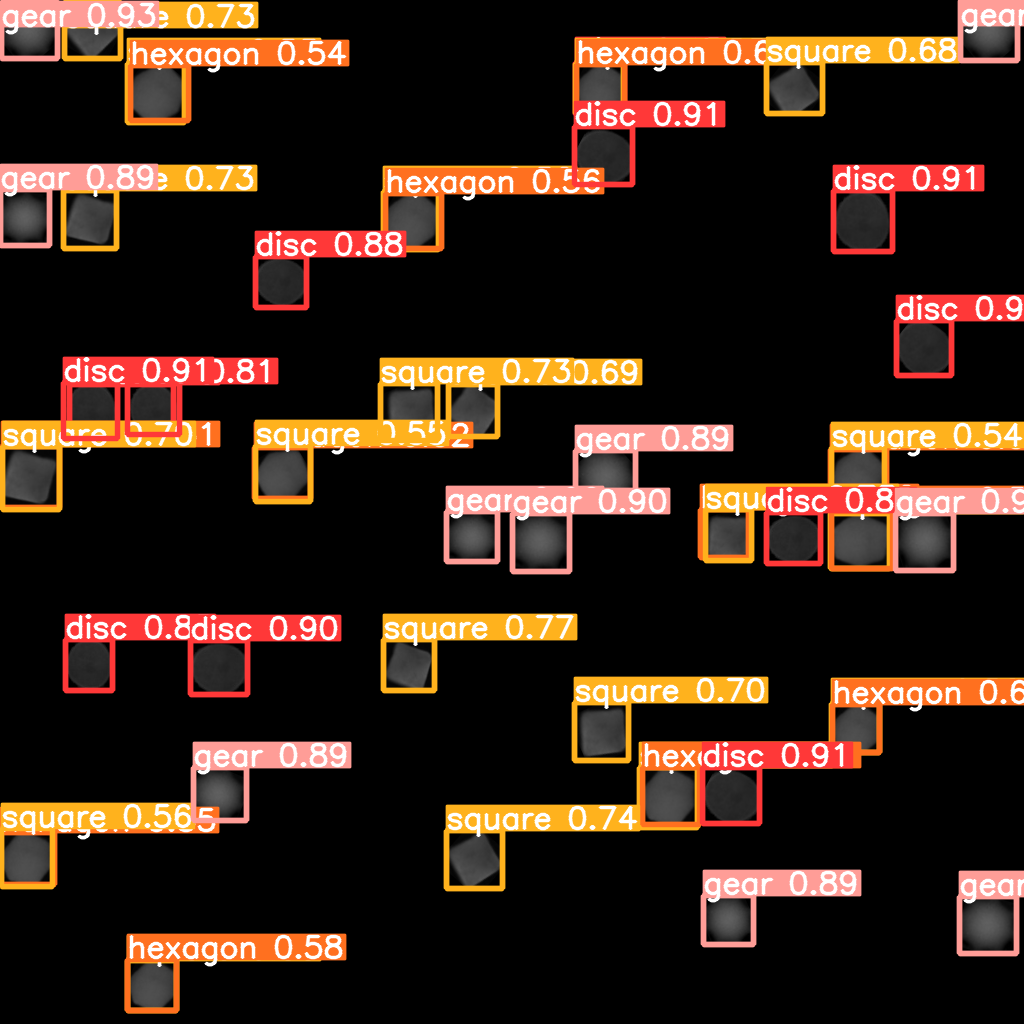

image 1/1: 1024x1024 11 discs, 10 gears, 15 hexagons, 20 squares
Speed: 28.3ms pre-process, 20.5ms inference, 1.9ms NMS per image at shape (1, 3, 640, 640)


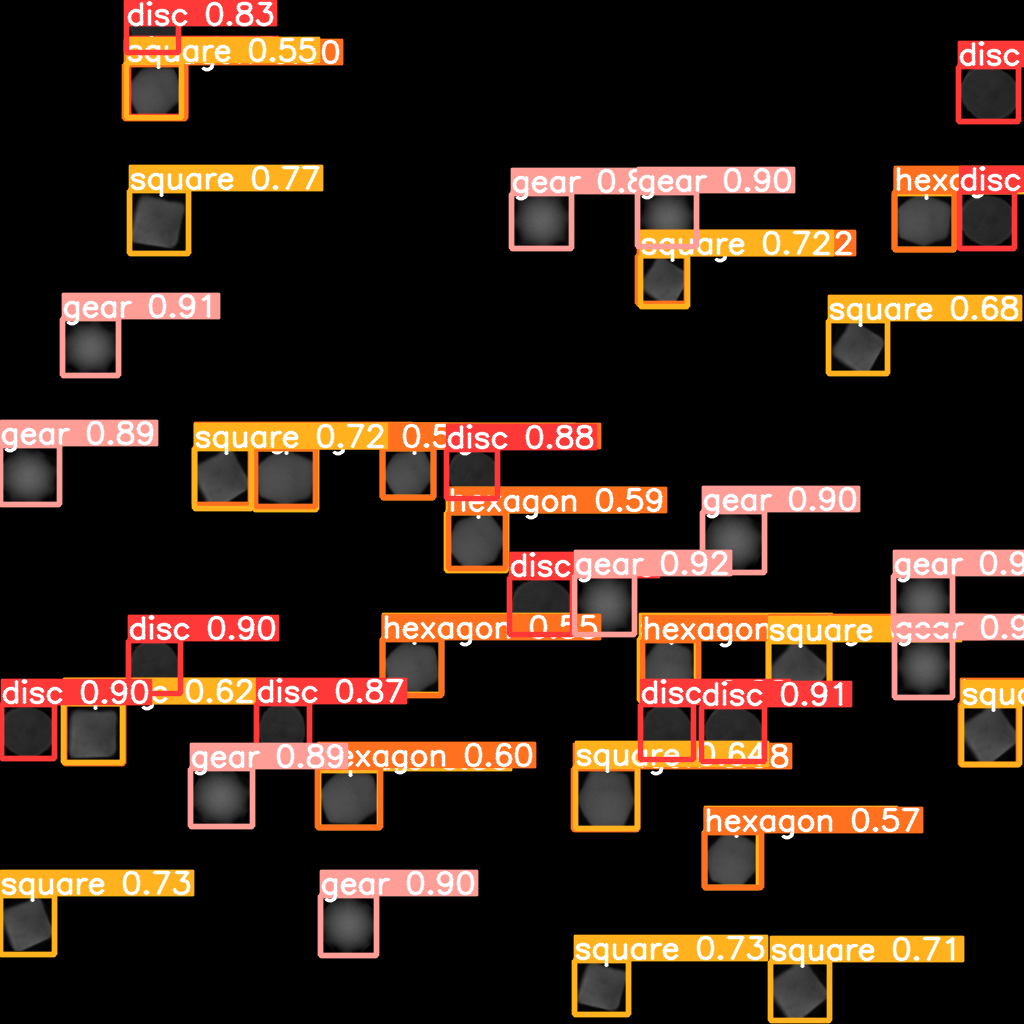

image 1/1: 1024x1024 11 discs, 11 gears, 11 hexagons, 20 squares
Speed: 27.3ms pre-process, 16.7ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)


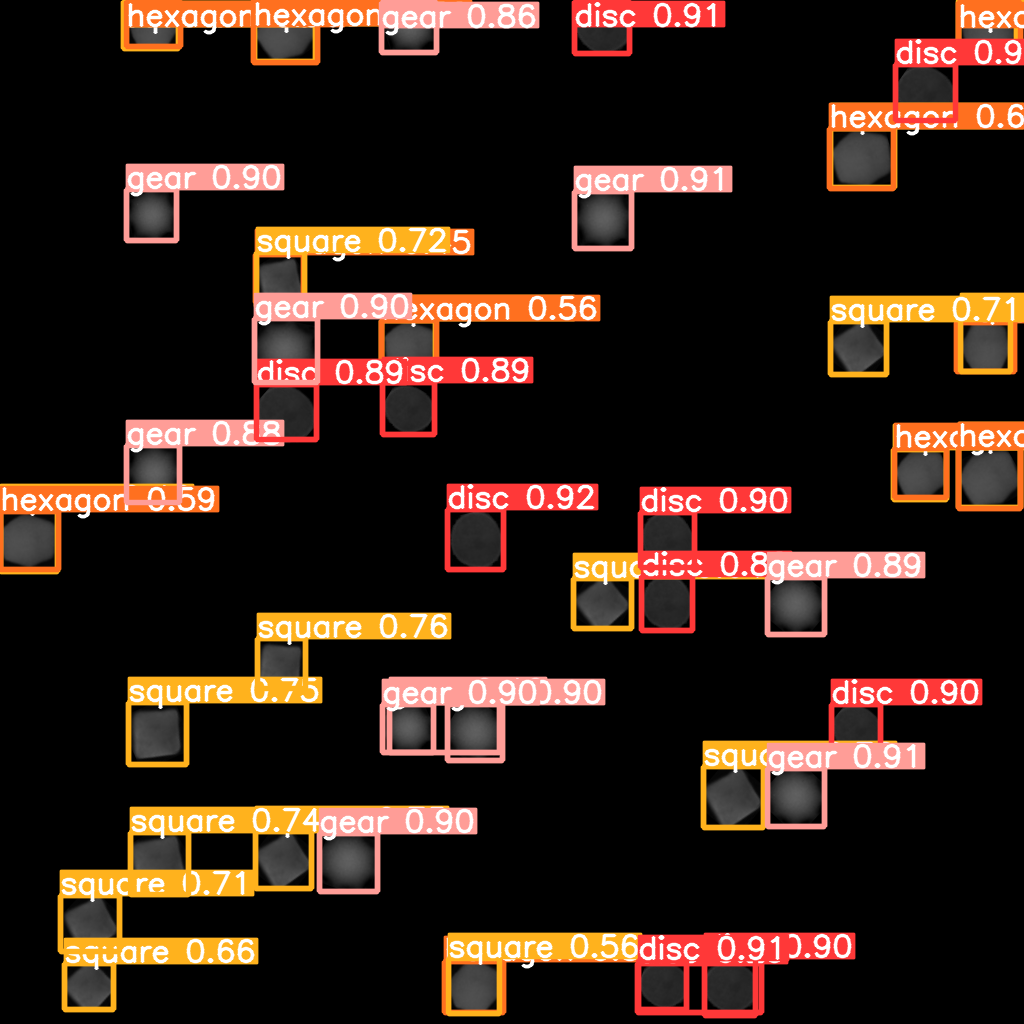

image 1/1: 1024x1024 12 discs, 11 gears, 13 hexagons, 20 squares
Speed: 25.5ms pre-process, 16.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 640)


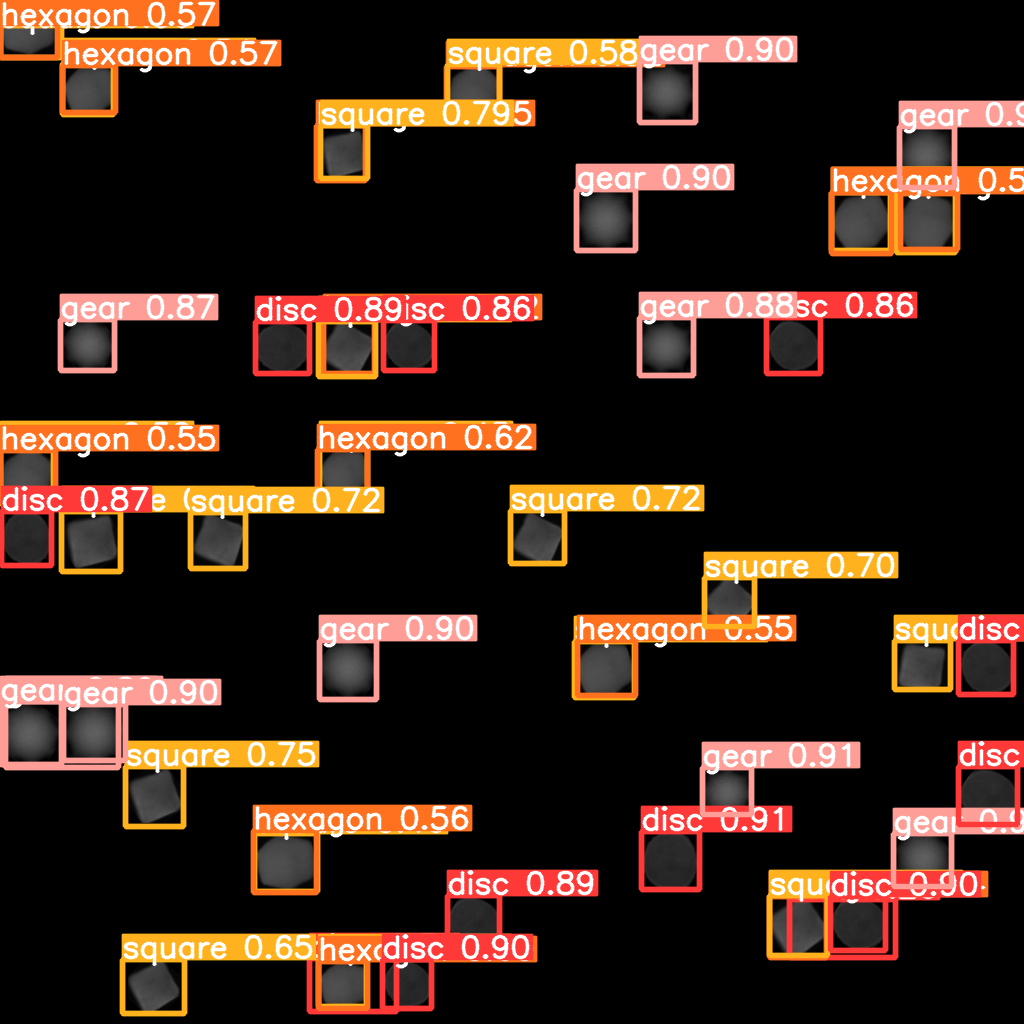

image 1/1: 1024x1024 13 discs, 11 gears, 14 hexagons, 20 squares
Speed: 21.8ms pre-process, 21.8ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)


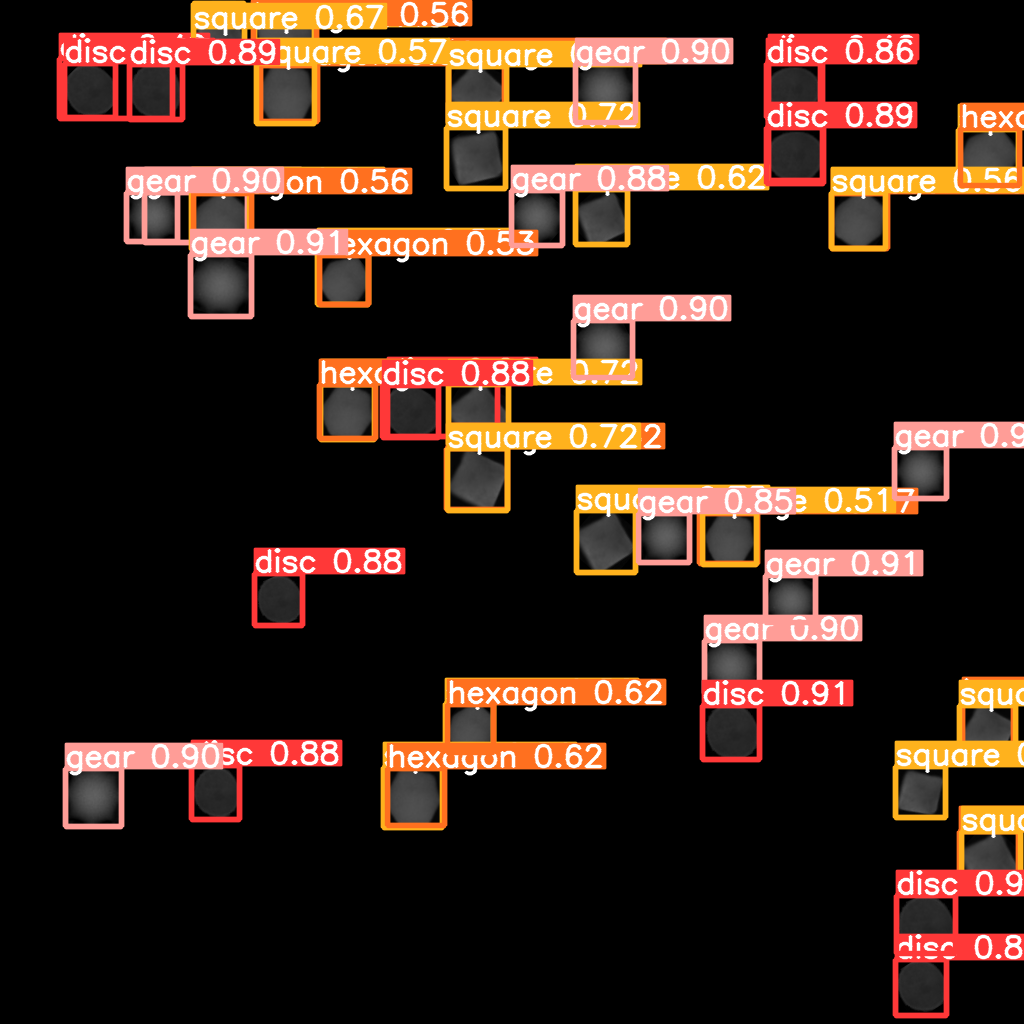

In [3]:
# Using the trained weights to detect the shapes in new images at Inference Time

import torch

# Load the trained model
# model = torch.hub.load("ultralytics/yolov5", "yolov5s", force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6, custom
model = torch.hub.load("ultralytics/yolov5", "custom", path='/content/sample_data/best.pt')

# Path to test data folder
# img = "https://ultralytics.com/images/zidane.jpg"  # or file, Path, PIL, OpenCV, numpy, list
test_folder_path = '/content/sample_data/test'

# Iterate through the images in the test folder
for image_name in os.listdir(test_folder_path):
  image_path = os.path.join(test_folder_path, image_name)

  # Inference - Performing detection
  results = model(image_path)

  # Get detected image
  detected_image = results.render()[0]

  # save path
  save_path = f'/content/drive/MyDrive/Colab Notebooks/Achira/gen/images/preds/{image_name}'

  # Save the image using OpenCV
  cv2.imwrite(save_path)

  # Print and show results
  results.print() # or .save(), .crop(), .pandas(), etc.
  results.show()

## Accuracy metrics:  

**Precision** : It indicates the number of true positive predictions out of the total predicted positives. A higher precision means that more of the objects the model labeled as "detected" were actual objects of interest.  

**Recall** : It represents the number of true positive predictions out of the total actual positives. A higher recall means that the model detected most of the actual objects present in the image.  

**mAP@0.5**: This is the mean Average Precision at an Intersection-over-Union (IoU) threshold of 0.5. It provides an average measure of the model's precision across different object sizes and is a commonly used metric for object detection tasks.  

**mAP@0.95**: This metric averages the mAP calculated at different IoU thresholds between 0.5 and 0.95. It's a stricter metric, as it considers various IoU levels, and provides a more comprehensive view of the model's performance across different object sizes and overlaps.

In [ ]:
# Plotting performance metrics: precision, recall, and mAP

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/sample_data/results.csv')
df.columns = df.columns.str.strip()

plt.figure(figsize=(15, 8))
# Plotting metrics
plt.plot(df['epoch'], df['metrics/precision'], label='Precision', color='blue')
plt.plot(df['epoch'], df['metrics/recall'], label='Recall', color='red')
plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5', color='green')
plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95', color='purple')

# Title and labels
plt.title('Performance Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

"""
# Alternate way

with open(path) as f:
  f.plot(confusion_matrix.png) # plotting confusion matrix
  f.plot(test.png)

# Plotting Precision
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/precision'], label='Precision', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.show()

# Plotting Recall
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/recall'], label='Recall', color='red')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()
plt.show()

# Plotting mAP@0.5
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP', color='green')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('mAP over Epochs')
plt.legend()
plt.show()

# Plotting mAP@0.5:0.95
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP', color='purple')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5:0.95')
plt.title('mAP over Epochs')
plt.legend()
plt.show()

"""

## Plotting losses per epoch

Train Box Loss (blue dashed line): This represents the loss associated with predicting the correct bounding boxes around objects.  
Train Object Loss (red dashed line): This is the loss associated with predicting the presence of an object.  
Train Class Loss (green dashed line): This represents the loss associated with predicting the correct class of an object.  

In [11]:
# Plotting the training and validation losses

plt.figure(figsize=(15, 8))

# Plot training losses
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue', linestyle='--')
plt.plot(df['epoch'], df['train/obj_loss'], label='Train Object Loss', color='red', linestyle='--')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', color='green', linestyle='--')

# Plot validation losses
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss', color='blue')
plt.plot(df['epoch'], df['val/obj_loss'], label='Validation Object Loss', color='red')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Class Loss', color='green')

# Title and labels
plt.title('Training and Validation Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Alternative way to plot results
!pip install utils

import utils
#import requests
from utils.plots import plot_results

plot_results('path/to/results.csv')  # plot 'results.csv' as 'results.png'

#  ⭐ YOLOv5 Architecture ⭐

1. Data Augmentation Techniques

YOLOv5 employs various data augmentation techniques to improve the model's ability to generalize and reduce overfitting. These techniques include:

**Mosaic Augmentation**: An image processing technique that combines four training images into one in ways that encourage object detection models to better handle various object scales and translations.  
**Copy-Paste Augmentation**: An innovative data augmentation method that copies random patches from an image and pastes them onto another randomly chosen image, effectively generating a new training sample.  


---


2. Compute Losses

The loss in YOLOv5 is computed as a combination of three individual loss components:

**Classes Loss (BCE Loss**): Binary Cross-Entropy loss, measures the error for the classification task.  
**Objectness Loss (BCE Loss)**: Another Binary Cross-Entropy loss, calculates the error in detecting whether an object is present in a particular grid cell or not.  
**Location Loss (CIoU Loss)**: Complete IoU loss, measures the error in localizing the object within the grid cell.  
The overall loss function is depicted by:

L = L(Obj) + L(Class) + L(Location)


---


3. 🔥 Transfer Learning with frozen layers -

YOLOv5 allows training the model using pretrained features except the fully connected layers. To do that,we can freeze any or all 24 layers as follows:


```
python train.py --freeze 24

```
Note : Interestingly, the more modules are frozen the less GPU memory is required to train, and the lower GPU utilization. This indicates that larger models, or models trained at larger image-size may benefit from freezing in order to train faster.


---


4. Fitness -

Fitness is the value we seek to maximize. YOLOv5 uses a fitness function as a weighted combination of metrics:   
mAP_0.5 contributes 10% of the weight and mAP_0.95 contributes the remaining 90%, with Precision P and Recall R absent.


---


5. Bounding Box Detection by YOLOv3 Head -

The head in YOLO architectures is responsible for producing the final detection boxes from the processed feature maps.
YOLOv3's head uses three different sizes of anchor boxes, leading to three different scales for detection. This design choice helps the network to detect small, medium, and large objects.
For each anchor box, YOLOv3 predicts multiple properties:   
an objectness score (how likely the box contains an object), 4 box coordinates (center x, center y, width, height), and class scores for every possible class (e.g., "building", "person").
Using a combination of these properties, YOLO determines both the location and type of each detected object in the input image.


6. Background images -   

Background images are images with no objects that are added to a dataset to reduce False Positives (About 0-10%). No labels are required for background images

7. Model Selection:  

Larger models like YOLOv5x and YOLOv5x6 will produce better results in nearly all cases, but will have more parameters, require more CUDA memory to train, and are slower to run. For mobile deployments, YOLOv5s/m is recommended, for cloud deployments, YOLOv5l/x is recommended.


**Alternate methods**


In [ ]:
# Using CNN Architecture

# Feeding images into model to detect
# set path to the dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Achira/train"

# Defining Hyperparameters
dim = 1024 # or input("Enter Dimensions:")
image_dimensions = (dim,dim) # dm = 1024, can be 512 or 2048 too
batch_size = 16 # or can take number of batches = 10 as total images = 100

tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,label_mode=None, image_size=image_dimensions, batch_size=batch_size
)

"""
can do scaling images from -1 to 1, but since we already have B&W images , it's not needed here . Has it been colour images, I would've done it to reduce computational resources
dataset = dataset.map(lambda x : (x-127.5)/127.5)
"""

Found 100 files belonging to 1 classes.


"\ncan do scaling images from -1 to 1, but since we already have B&W images , it's not needed here . Has it been colour images, I would've done it to reduce computational resources\ndataset = dataset.map(lambda x : (x-127.5)/127.5)\n"

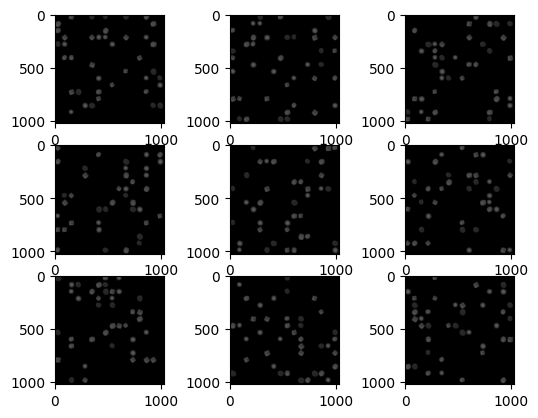

In [ ]:
from matplotlib import pyplot

# Display grid of images from dataset
def display_images(total=9): # default total images to display = 9
    num=total
    for x in dataset:
        pyplot.subplot(330 + 1 + total - num)
        plt.imshow( (x.numpy()).astype("int32")[0]) #pyplot.imshow((x.numpy() * 255).astype("int32")[0])
        num-=1
        if not num:
            break

display_images()

In [ ]:
#class_names = dataset.class_names
#print(class_names)
print(len(dataset))

100


In [ ]:
# splitting into train, validation and test data

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    ds_size= len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds), len(val_ds), len(test_ds))
train_ds

80 10 10


<_TakeDataset element_spec=TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None)>

In [ ]:
# building a CNN model
n_classes = 4
input_shape = (dim,dim,3)
#input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
model = models.Sequential([
    layers.Conv2D(32, (4,4), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (4,4), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])

"\nlayers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),\nlayers.MaxPooling2D((2,2)),\nlayers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),\nlayers.MaxPooling2D((2,2)),\nlayers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),\nlayers.MaxPooling2D((2,2)),\nlayers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),\nlayers.MaxPooling2D((2,2)),\n"

In [ ]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1021, 1021, 32)    1568      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 510, 510, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 507, 507, 64)      32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 253, 253, 64)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096576)           0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
model.compile(
	optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs = 1, batch_size = 1, verbose=1, validation_data = val_ds)

#### IF ANY ISSUES, CONNECT ON MAIL/LINKEDIN